In [ ]:
# load libraries
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import save,load
from torch import nn
from collections.abc import Sequence
from tqdm import tqdm

/home/pierbon/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
class CustomDataset(Dataset):
  def __init__(self, df_train, df_test, transform = None, target_transform = None):
    self.features = torch.FloatTensor(df_train.drop(['sensor_code','in_datetime'],axis=1).values)
    ### standardize the data
    means = self.features.mean(dim=1, keepdim=True)
    stds = torch.clamp(self.features.std(dim=1, keepdim=True),min=1)
    self.features = (self.features - means) / stds
    self.target = torch.FloatTensor(df_test.drop(['sensor_code','in_datetime']+[f"val_{idx}" for idx in range(n_previsions)],axis=1).values)
    self.target = (self.target - means) / stds
    
    self.sensor_code = df_train['sensor_code'].values
    self.in_datetime = df_train['in_datetime'].values
    
    self.labels = torch.FloatTensor(df_test[[f"val_{idx}" for idx in range(n_previsions)]].values)
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.sensor_code)

  def __getitem__(self, idx):
    sensor_code = self.sensor_code[idx]
    date = self.in_datetime[idx]
    features = self.features[idx]
    labels = self.labels[idx]
    target = self.target[idx]
    return {"sensor_code": sensor_code, "date":date,"features": features, "target":target,"labels":labels}

In [ ]:
splits = ['train','test']
shuffle = {'train':True,'test':False}
dataset = {}

dataset['train'] = load('converted dataset/pytorch dataset/T0071_train_radiazione_solare_tsf.pt')
dataset['test'] = load('converted dataset/pytorch dataset/T0071_test_radiazione_solare_tsf.pt')

b_size = {'train':64,
          'test':len(dataset['test'])}

dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x,
                                            drop_last=True)
                                            #num_workers=int(opt.workers),
                                            #worker_init_fn=(None if opt.manualseed == -1
                                            #else lambda x: np.random.seed(opt.manualseed)))
            for x in splits}

In [ ]:
sample = next(iter(dataloader['train']))
sample_tensor_features = torch.stack([v["features"] for v in sample])
wh_nans = (torch.isnan(sample_tensor_features)).nonzero(as_tuple=True)
print(wh_nans)
# plt.plot(sample_tensor_features[1].numpy())

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))


In [ ]:
import torch
from torch import nn

class SingleLSTMCell(nn.Module):
    def __init__(self, input_size, output_size, batch_size, hidden_dim,device):
        super(SingleLSTMCell, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim

        # Define the torch device
        self.device = device

        # LSTM Cell
        self.lstm1 = nn.LSTMCell(input_size, hidden_dim)
        # self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # Initializing hidden state only once
        self.hidden,self.cell = self.init_hidden_and_cell(batch_size)

    def forward(self, x, pred_fut=0):
        outputs, batch_size = [], x.size(0)

        # Initializing hidden state for first input using method defined below
        # hidden,cell = self.init_hidden_and_cell(batch_size)
        
        # Initializing hidden state only once
        hidden,cell = self.hidden, self.cell
        
        # x = torch.unsqueeze(x, 2)
        for time_step in x.split(1, dim=1):
            hidden,cell = self.lstm1(time_step, (hidden,cell))
            output = self.fc(hidden) # output from the last FC layer
            outputs.append(output)
        
        if(pred_fut):
            for i in range(pred_fut):
                # this only generates future predictions if we pass in future_preds>0
                # mirrors the code above, using last output/prediction as input
                hidden,cell = self.lstm1(output, (hidden,cell))
                output = self.fc(hidden)
                outputs.append(output) 
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    
    def init_hidden_and_cell(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(batch_size, self.hidden_dim).to(self.device)
        cell = torch.zeros(batch_size, self.hidden_dim).to(self.device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden,cell

class LSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, device):
        super(LSTM, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim

        # Define the torch device
        self.device = device

        # LSTM Cell
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_dim, num_layers = 2, 
                            batch_first=True, dropout=0.2)
        # self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
        # Initializing hidden state only once
        # self.hidden,self.cell = self.init_hidden_and_cell(batch_size)

    def forward(self, x, pred_fut=0):
        outputs, batch_size, sequence_length = [], x.size(0), x.size(1)

        # initialize hidden and cells
        h0 = torch.zeros(2, batch_size, self.hidden_dim).requires_grad_().to(self.device)
        c0 = torch.zeros(2, batch_size, self.hidden_dim).requires_grad_().to(self.device)
        x = x.unsqueeze(2)
        # the first part of the output is the already known curve
        outputs = x

        for i in range(pred_fut):
            # this generates future predictions, aslo based on subsequent predictions
            
            # selection of the window
            outputs_window = outputs[:,i:sequence_length+i,:]
            output, (h0, c0) = self.lstm(outputs_window, (h0, c0))
            output = self.fc(h0[0])
            output = nn.LeakyReLU(negative_slope=0.3)(output)
            # append the predicted point to the output
            outputs = torch.cat((outputs, output.unsqueeze(2)), dim=1)
            
        return outputs.squeeze(2).to(device)
    
    def init_hidden_and_cell(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(batch_size, self.hidden_dim).to(self.device)
        cell = torch.zeros(batch_size, self.hidden_dim).to(self.device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden,cell

**LSTM Hyperparametri**
batch_size: 64, n_layer: 2, dropout: 0.2, hidden_dim: 10, epochs: 20, learning_rate: 0.0001, filtro: MSEloss, optimizer: Adam

In [ ]:
device = torch.device("cuda:0")
sequence_length = 96
pred_length = 4
loss_array = []

# Instantiate the model with hyperparameters
model = LSTM(input_size=1, output_size=1, hidden_dim=10, device = device).to(device)

# Define hyperparameters
lr = 0.0001

# Define Loss, Optimizer
criterion =  nn.MSELoss() #nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

n_epochs = 20
for epoch in range(1, n_epochs + 1):
    for data in tqdm(dataloader['train'], leave=True, total=len(dataloader['train'])):
        batch_input_features = torch.stack([v["features"] for v in data]).to(device)
        target_features = torch.stack([v["target"] for v in data]).to(device)
        output = model(batch_input_features,pred_length)
        output = output.to(device)[:,-pred_length:]
        loss = criterion(output, target_features)
        loss.backward() # Does backpropagation and calculates gradients
        optimizer.step() # Updates the weights accordingly
        # print("Loss: {:.4f}".format(loss.item()))
    if loss.item() < 0.015:
        break
    loss_array.append("{:.4f}".format(loss.item()))
    print("Loss: {:.4f}".format(loss.item()))
# torch.save(model.state_dict(), "T0065_rad_sol_model.pt")

100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 140.62it/s]


Loss: 1.0245


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 144.03it/s]


Loss: 0.6296


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 143.93it/s]


Loss: 0.4320


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 149.77it/s]


Loss: 0.2739


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 155.87it/s]


Loss: 0.2617


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 155.02it/s]


Loss: 0.2191


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 149.94it/s]


Loss: 0.1771


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 151.71it/s]


Loss: 0.1731


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 145.83it/s]


Loss: 0.1645


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 143.39it/s]


Loss: 0.1962


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 144.32it/s]


Loss: 0.1777


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 143.55it/s]


Loss: 0.1614


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 143.44it/s]


Loss: 0.1717


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:04<00:00, 130.71it/s]


Loss: 0.1625


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 148.01it/s]


Loss: 0.1528


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 145.02it/s]


Loss: 0.1496


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 147.44it/s]


Loss: 0.1562


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 148.80it/s]


Loss: 0.1664


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 145.86it/s]


Loss: 0.1616


100%|████████████████████████████████████████████████████████████████████████████████| 553/553 [00:03<00:00, 144.17it/s]

Loss: 0.1596


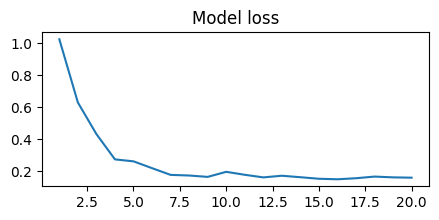

In [ ]:
x0 = [float(i+1) for i in range(n_epochs)]
loss_progress = [float(i) for i in loss_array]
plt.figure(figsize=(5, 2))
plt.plot(x0, loss_progress)
plt.title('Model loss')
plt.savefig('model_loss.png')
plt.show()

Il dataset non presenta anomalie, quindi non viene testato il treshold da impostare, ma soltanto la ricostruzione

In [ ]:
b_size = {'train':64,
          'test':len(dataset['test'])}
shuffle = {'train':False,'test':False}


dataloader = {x: torch.utils.data.DataLoader(dataset=dataset[x],
                                            batch_size=b_size[x],
                                            shuffle=shuffle[x],
                                            collate_fn=lambda x: x,
                                            drop_last=True) for x in splits}
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])
sample_tensor_features = torch.stack([v["features"] for v in sample])
print((sample_tensor_validation == 140).nonzero(as_tuple=True))
print(sample_tensor_features.size())

(tensor([], dtype=torch.int64), tensor([], dtype=torch.int64))
torch.Size([8858, 96])


Il modello si aspetta sempre una crescita graduale delle radiazioni, ecco alcuni esempi

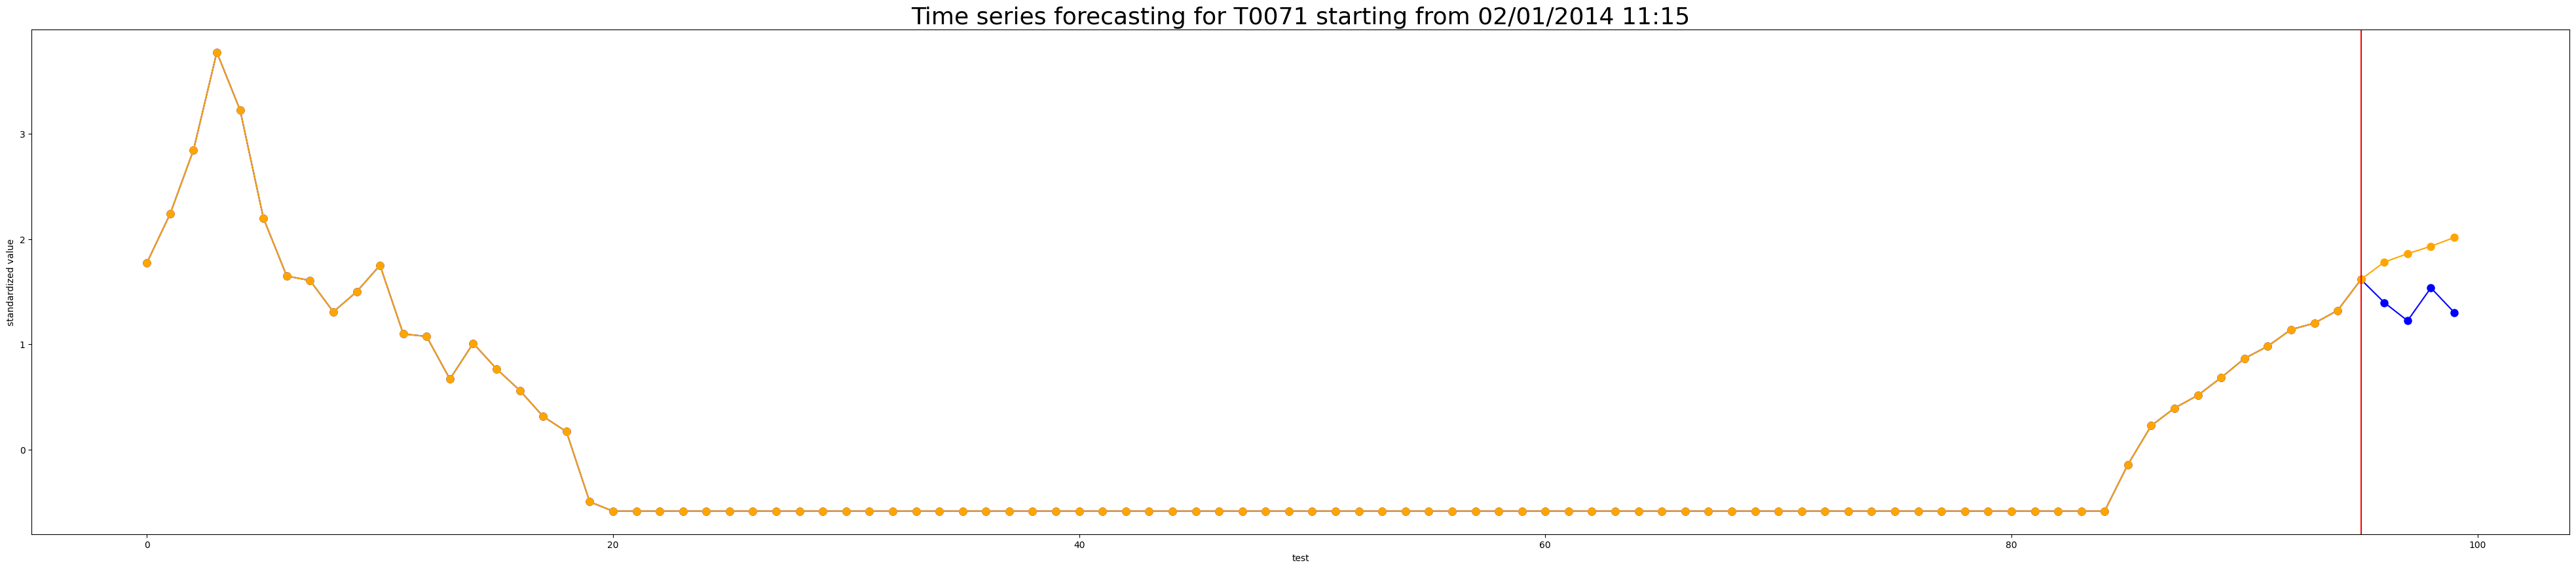

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 6
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')

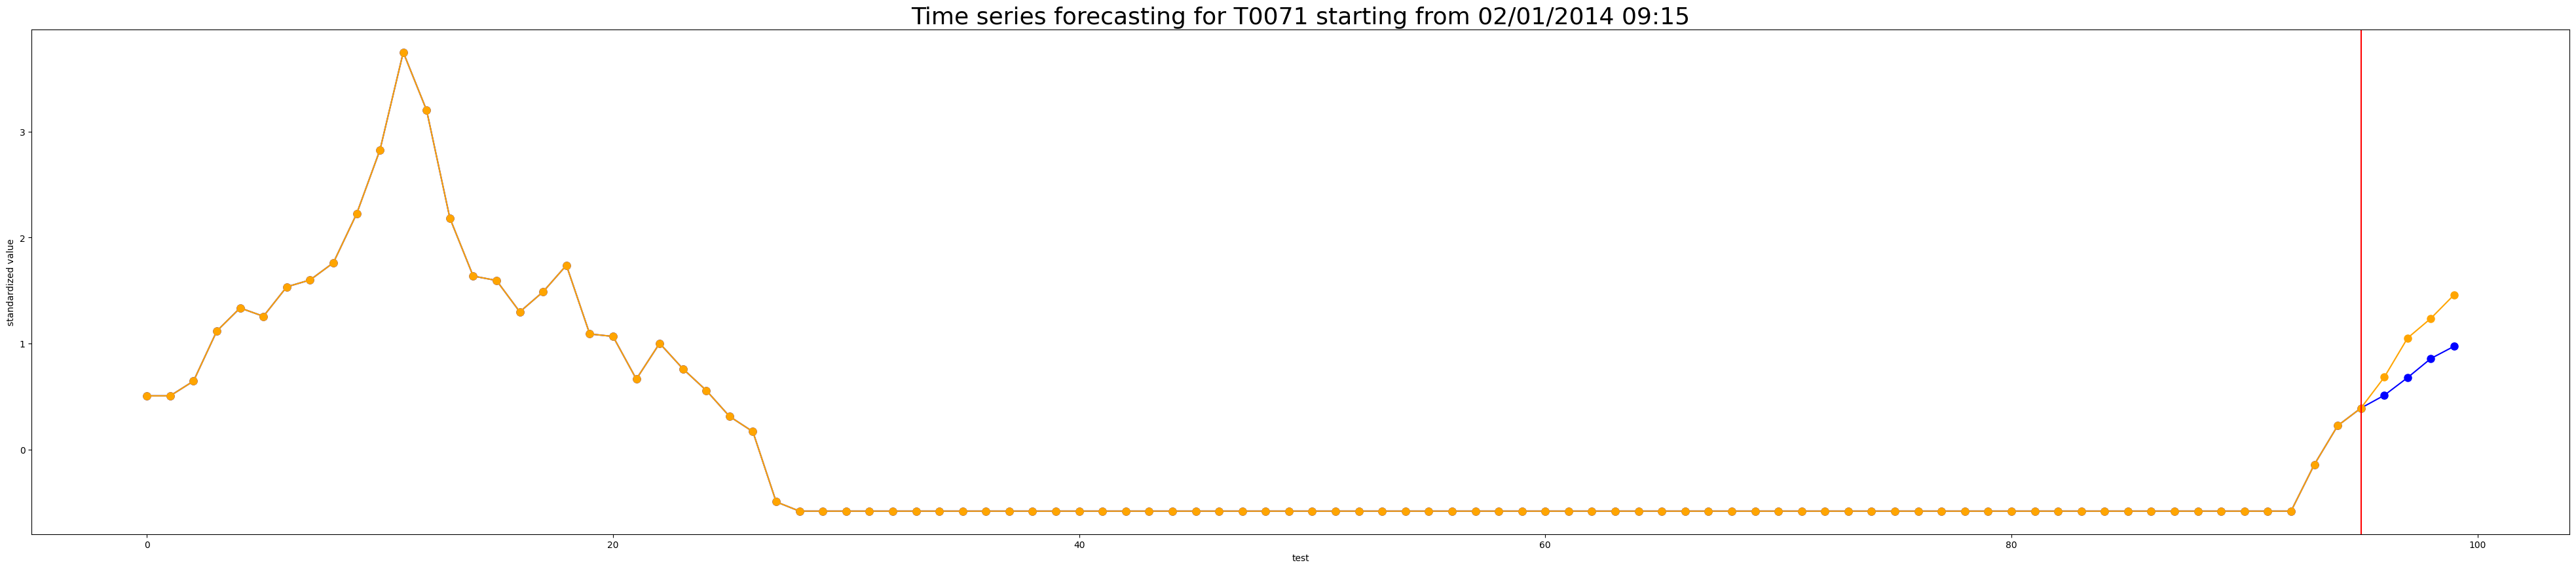

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 5
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')

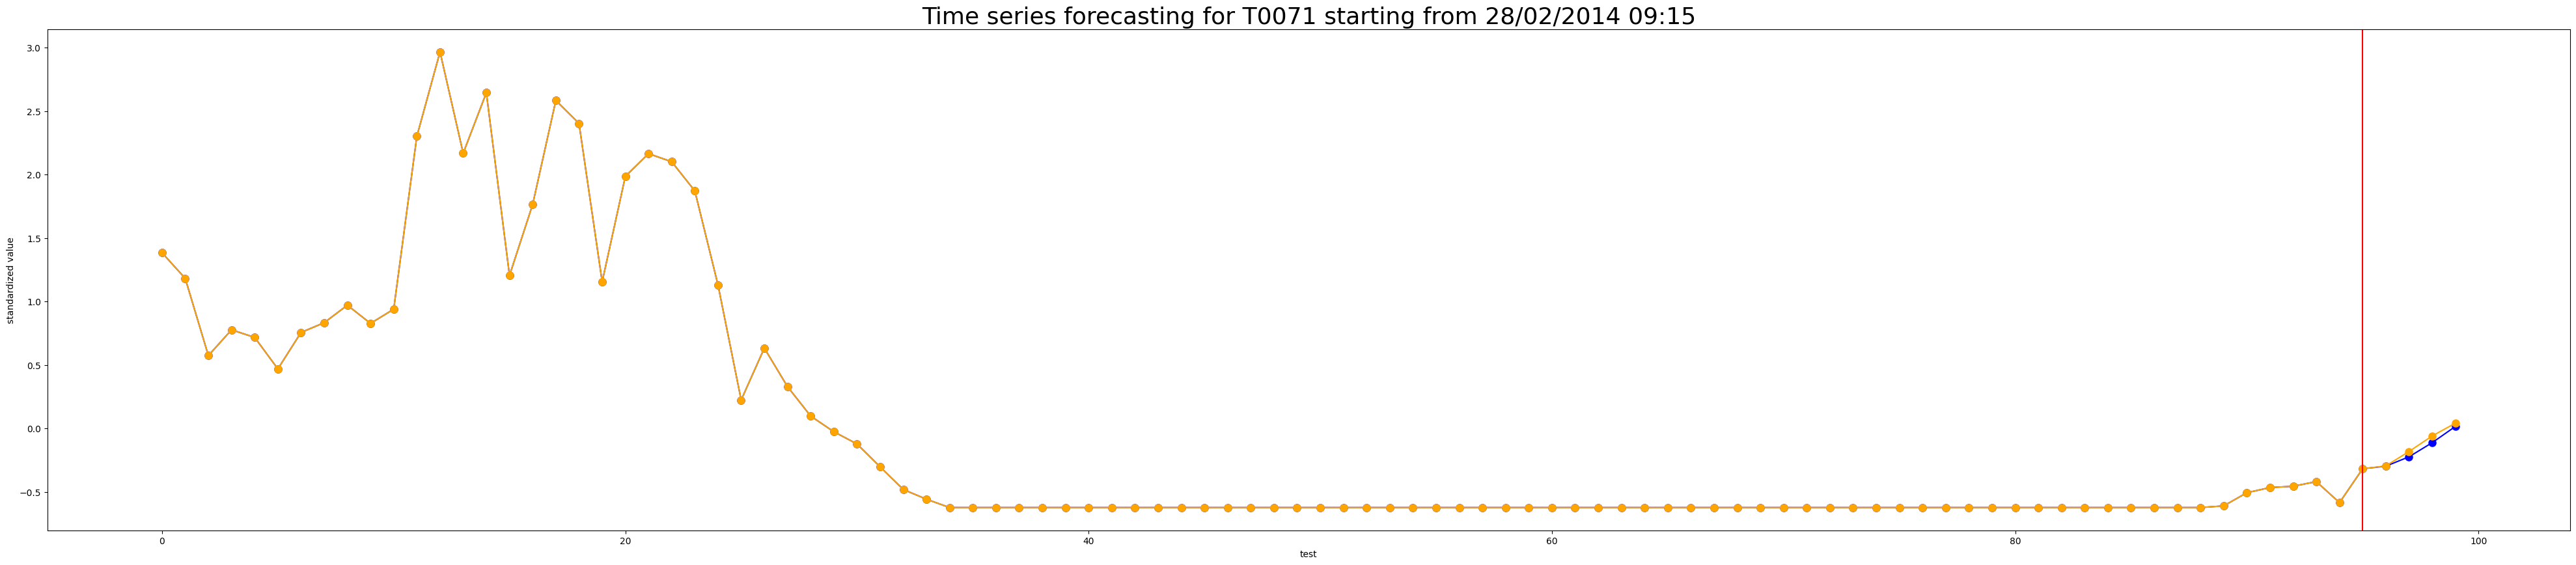

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 245
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')

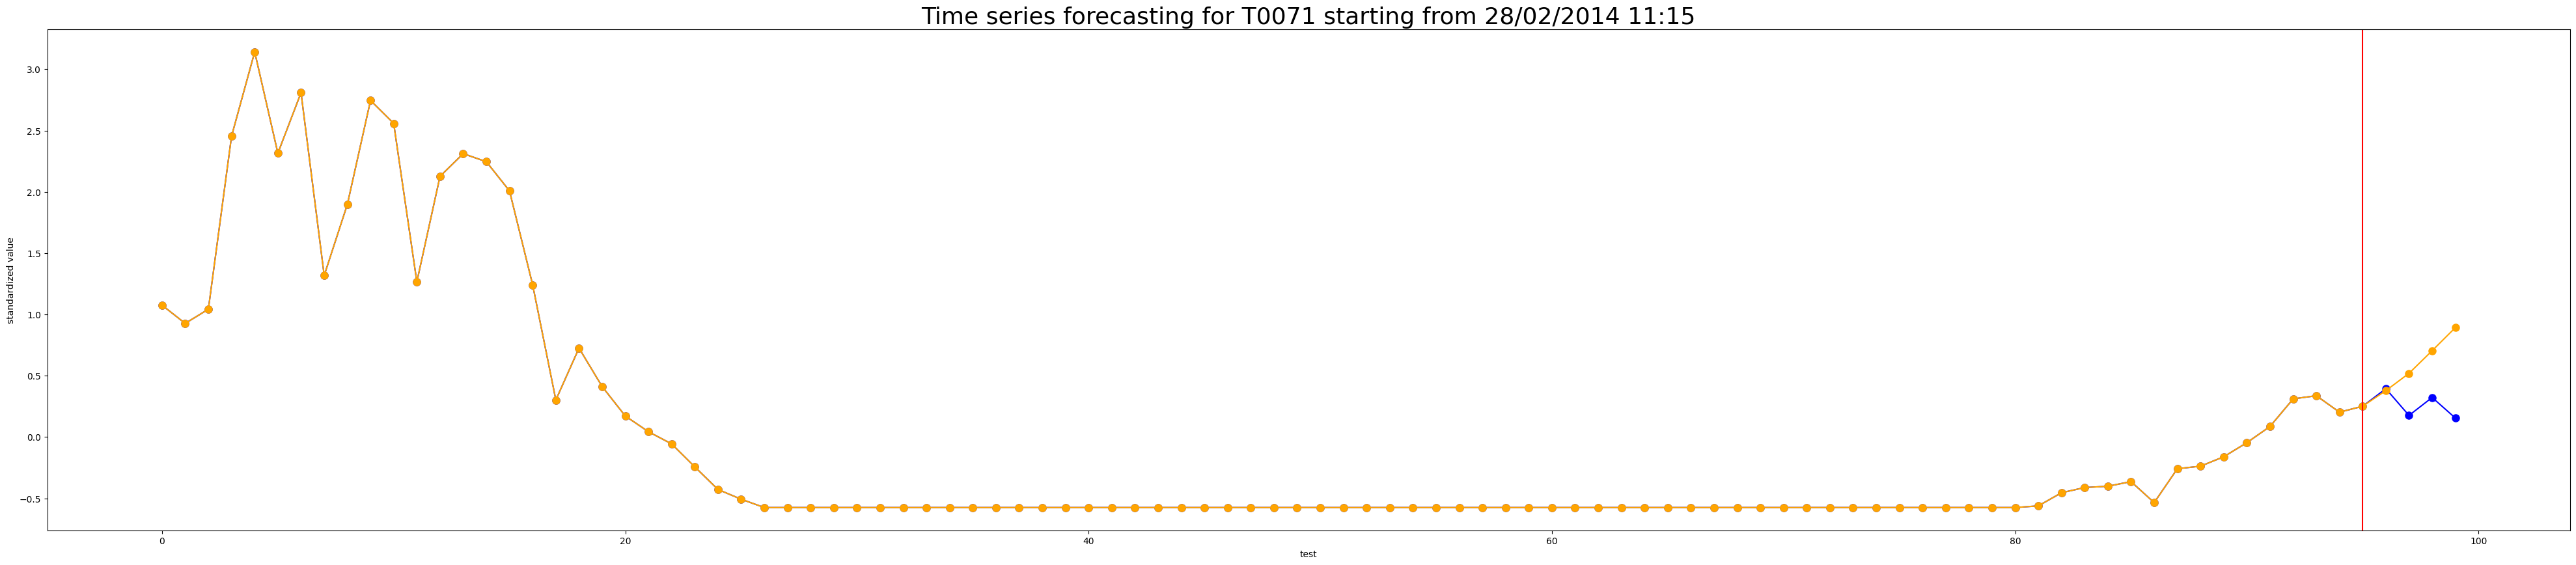

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 246
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')

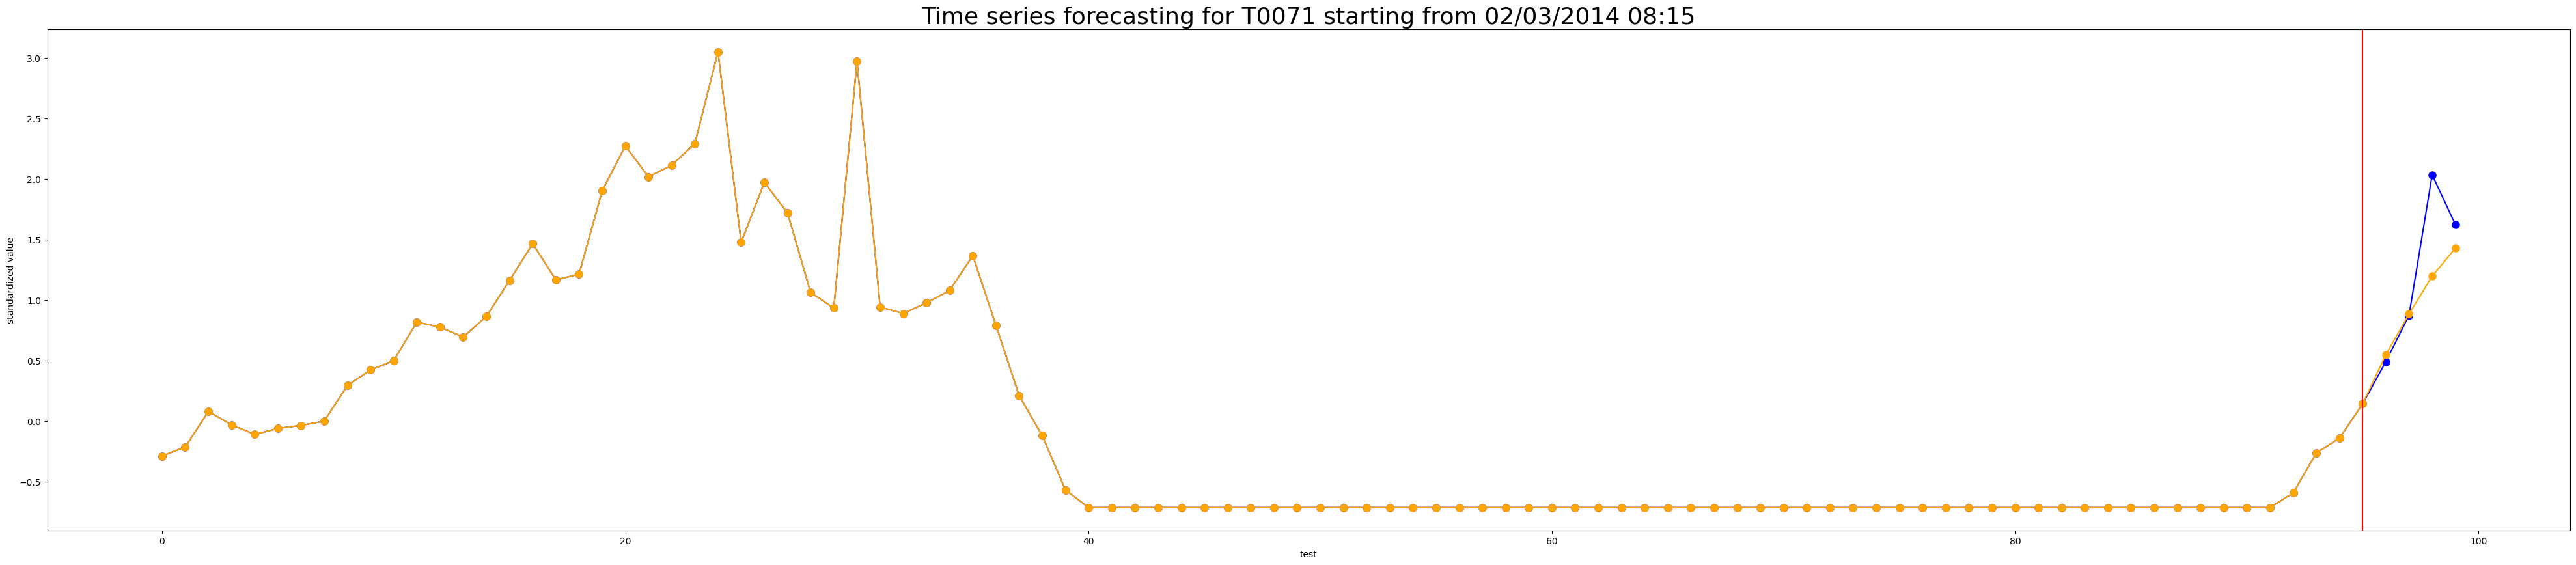

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 257
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')

La ricostruzione durante il giorno stima dopo il picco di mezzogiorno una discesa anch'essa graduale

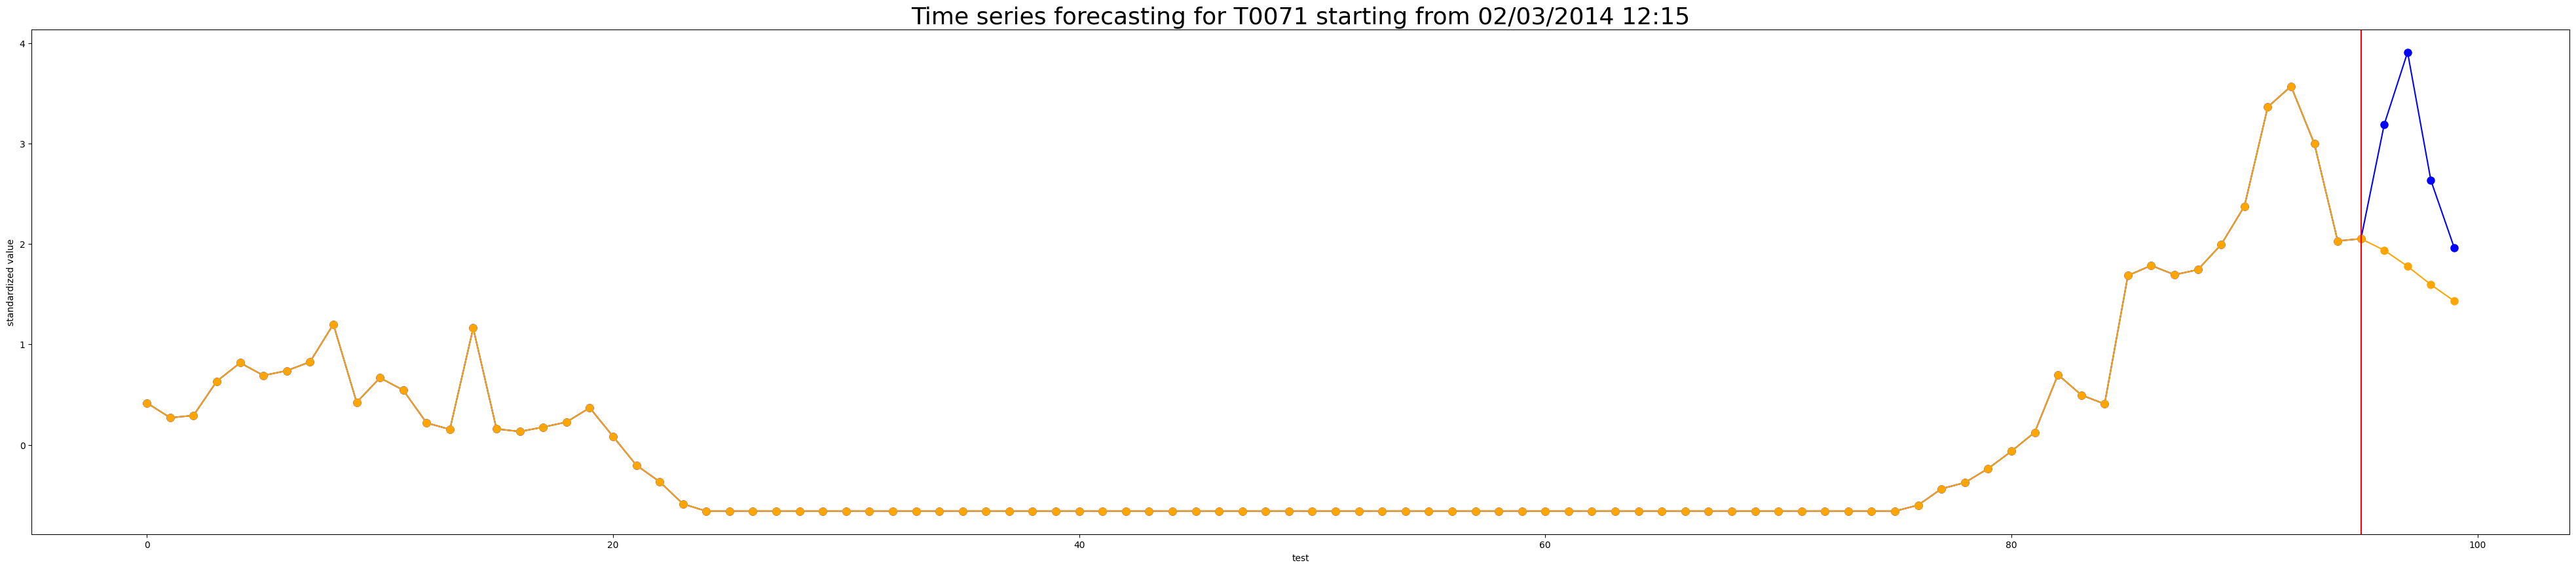

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 258
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')

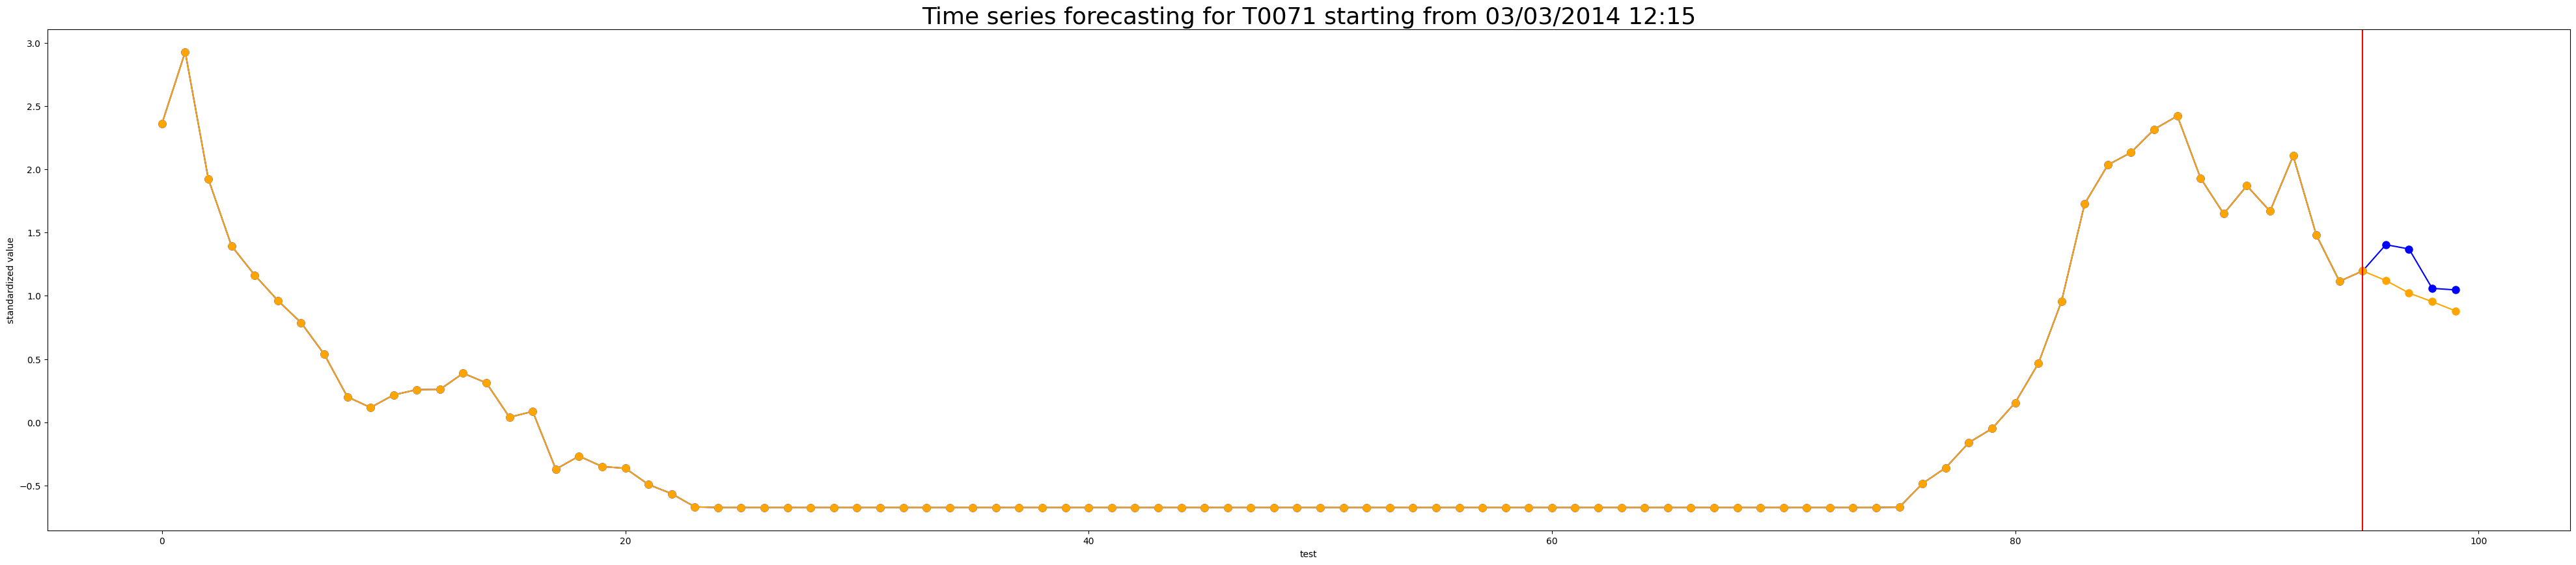

In [ ]:
f = plt.figure()
f.set_figwidth(50)
f.set_figheight(10)
plt.ylabel('standardized value')
plt.xlabel('test')
which = 0
anomaly = 260
sample = next(iter(dataloader['test']))
sample_tensor_validation = torch.stack([v["labels"] for v in sample])

sample_tensor_validation = sample_tensor_validation[anomaly:anomaly+64,:]

sample_tensor_features = torch.stack([v["features"] for v in sample]).to(device)

sample_tensor_features = sample_tensor_features[anomaly:anomaly+64,:]

sample_tensor_target = torch.stack([v["target"] for v in sample]).to(device)
sample_tensor_target = sample_tensor_target[anomaly:anomaly+64,:]

sensor_code = [v["sensor_code"] for v in sample][anomaly]
date = pd.to_datetime([v["date"] for v in sample][anomaly],format = '%d/%m/%Y %H:%M').strftime("%d/%m/%Y %H:%M") 

string_to_plot = f"{sensor_code} starting from {date}"
plt.title('Time series forecasting for ' +string_to_plot ,fontsize = 26)

model.eval()
with torch.no_grad():
    reconstructed = model(sample_tensor_features,4)
y_outliers = np.where(sample_tensor_validation[which].to("cpu") != 140, np.NaN, sample_tensor_target[which][0:4].to("cpu"))# plt.xlim(96,102)
original_signal = torch.cat((sample_tensor_features, sample_tensor_target), 1)[which]

plt.plot(original_signal.to("cpu"), "o-",ms=8,color="blue")
plt.plot(reconstructed[which].to("cpu"),"o-",ms=8,color="orange")
plt.plot(np.arange(96,100), y_outliers, "x-",ms=15,mew=10,color="red")
plt.axvline(x=95, color='red')